In [1]:
# classification (natural language processing (nlp))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.metrics import classification_report, confusion_matrix
import missingno as mns
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
nltk.download('stopwords')
stop_words = stopwords.words('english') 

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
df =pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


<Axes: >

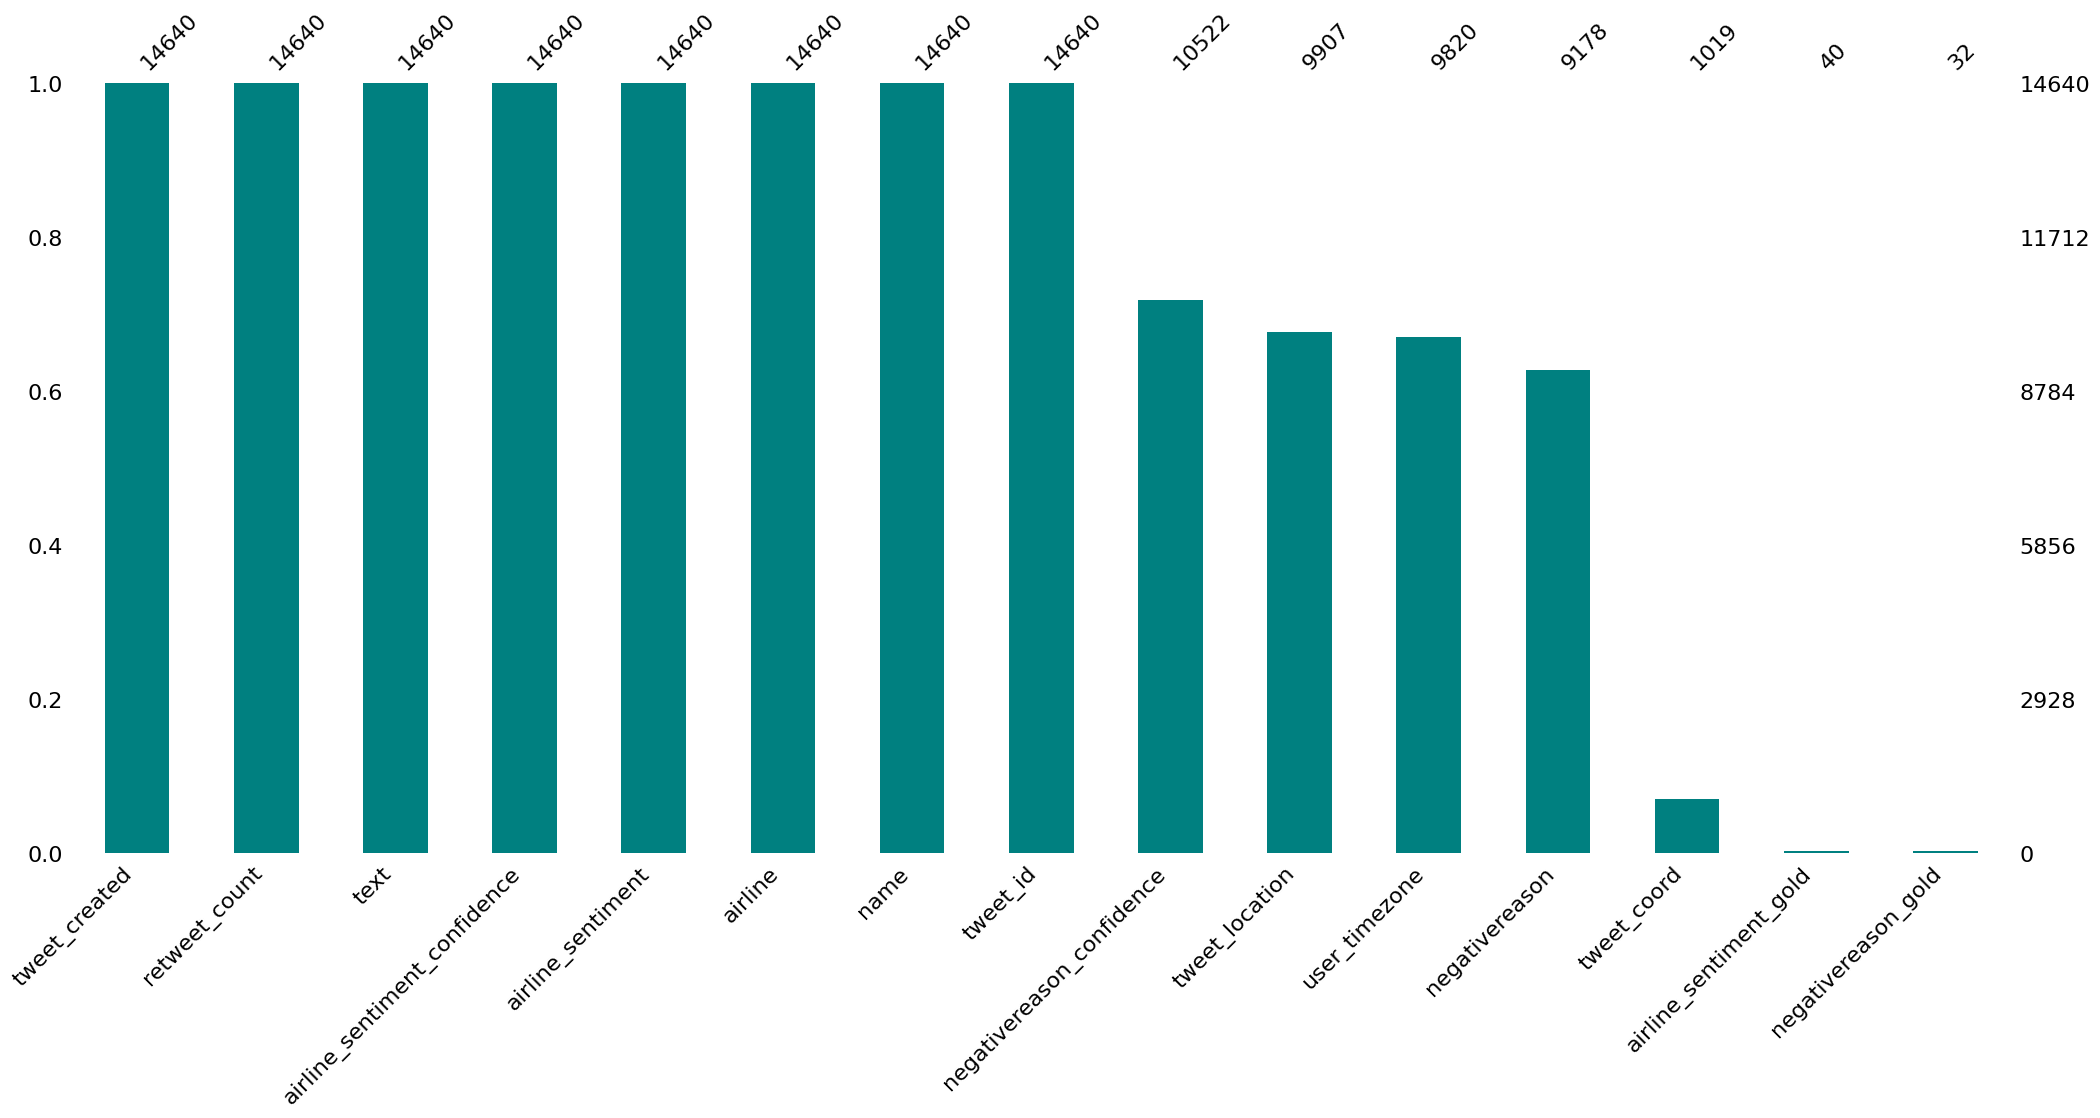

In [3]:
# here only 2 columns is important, the text column and the outcome colunm
# use a diff way to check missing values
# outcome column should be airline_sentiment while the text column is text 
# only the text and outcome value may be filled and not filling but drop only the row with missig value
# the result shows the columns of interst are all complete 
mns.bar(df, color = 'teal', sort = 'descending')

In [4]:
# check why the negative using the negativereason column 
fig = px.histogram(x = df['airline'], text_auto= True, color = df['negativereason'])
fig.show()

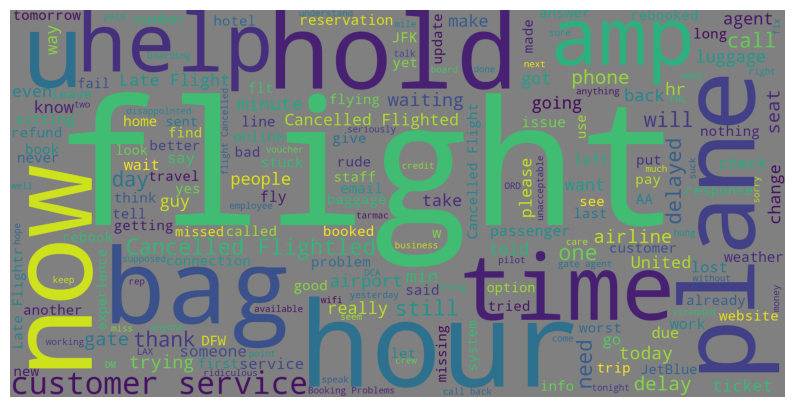

In [5]:
# to build the machine learning model, we need to build worldcloud which is a color representation of text
newdata = df[df['airline_sentiment'] == 'negative']
word = " ".join(newdata['text'])
# to clean the text (remove all the http, @)
clw = " ".join([word for word in word.split() if 'http' not in word and not word.startswith ('@') and word != 'RT'])
# to remove all the stopwords eg by, the, at (they are not relevant at analysis)
wc = WordCloud(stopwords = STOPWORDS, background_color = 'grey', width = 2000, height = 1000).generate(clw)
plt.figure(1, figsize = (10,10))
plt.imshow(wc) 
plt.axis('off')
plt.show()
# the bigger the word meaning the more frequent it occured


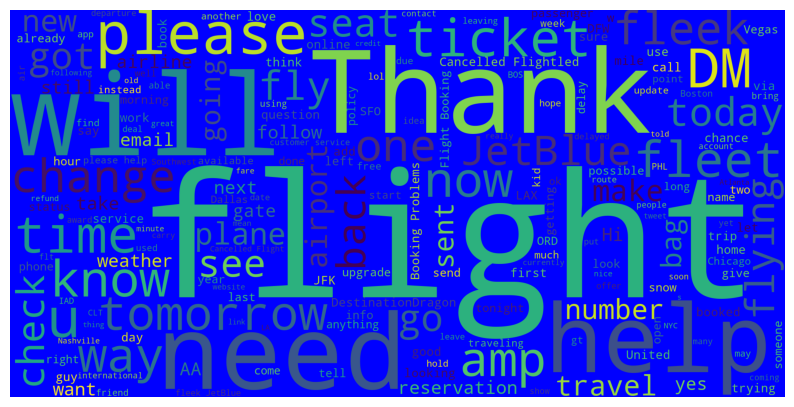

In [6]:
# to build the machine learning model, we need to build worldcloud which is a color representation of text
newdata = df[df['airline_sentiment'] == 'neutral']
word = " ".join(newdata['text'])
# to clean the text (remove all the http @)
clw = " ".join([word for word in word.split() if 'http' not in word and not word.startswith ('@') and word != 'RT'])
# to remove all the stopwords eg by, the, at (they are not relevant at analysis)
wc = WordCloud(stopwords = STOPWORDS, background_color = 'blue', width = 2000, height = 1000).generate(clw)
plt.figure(1, figsize = (10,10))
plt.imshow(wc) 
plt.axis('off')
plt.show()

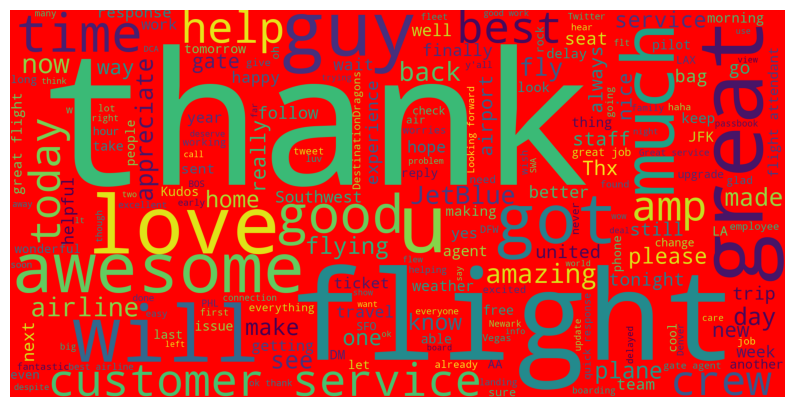

In [7]:
# to build the machine learning model, we  need to build worldcloud which is a color representation of text
newdata = df[df['airline_sentiment'] == 'positive']
word = " ".join(newdata['text'])
# to clean the text (remove all the http @)
clw = " ".join([word for word in word.split() if 'http' not in word and not word.startswith ('@') and word != 'RT'])
# to remove all the stopwords eg by, the, at (they are not relevant at analysis)
wc = WordCloud(stopwords = STOPWORDS, background_color = 'red', width = 2000, height = 1000).generate(clw)
plt.figure(1, figsize = (10,10))
plt.imshow(wc) 
plt.axis('off')
plt.show()

In [8]:
# data balancing
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [9]:
from sklearn.utils import resample
df_negative = df[df['airline_sentiment'] == 'negative']
df_neutral = df[df['airline_sentiment'] == 'neutral']
df_positive = df[df['airline_sentiment'] == 'positive']
df_sam = resample(df_neutral, n_samples = 9178)
df_sam1 = resample(df_positive, n_samples = 9178)
df = pd.concat([df_negative, df_sam, df_sam1], ignore_index=True)
df = df.sample(frac = 1)
df['airline_sentiment'].value_counts()


airline_sentiment
positive    9178
negative    9178
neutral     9178
Name: count, dtype: int64

In [10]:
# next thing is the proper text cleaning
# x is for the text in each row
# strip is to remove any space in front or back else it will be read as character
# stem is to return all original word without prefix of surfix
text_cleaning_re = "!@#$%^&*HTTP?><[A-Za-z0-9]+"
def preprocess(x, stem = False):
    x = re.sub(text_cleaning_re, " ", str(x).lower()).strip()
    tokens = []
    for token in x.split():
        if token not in stop_words:
            if stem:
                tokens.append(SnowballStemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
df['text'] = df['text'].apply(lambda x:preprocess(x))

In [11]:
# machine learning
# pipeline put several function in one (preprocessing, split to x and y and create/train model )
x = df.text
y = df['airline_sentiment']
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size= 0.2, random_state= 1)
from sklearn.pipeline import Pipeline
clf1 = Pipeline([('vectorizer',CountVectorizer()), ('transformer', TfidfTransformer()), ('model', MultinomialNB())])
clf2 = Pipeline([('vectorizer',CountVectorizer()), ('transformer', TfidfTransformer()), ('model', BernoulliNB())])
clf3 = Pipeline([('vectorizer',CountVectorizer()), ('transformer', TfidfTransformer()), ('model', MLPClassifier(hidden_layer_sizes=(10,10)))])


In [12]:
clf1.fit(xtrain,ytrain)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('transformer', TfidfTransformer()),
                ('model', MultinomialNB())])

In [13]:
pred1 = clf1.predict(xtest)
print(classification_report(ytest,pred1))

              precision    recall  f1-score   support

    negative       0.82      0.86      0.84      1805
     neutral       0.86      0.79      0.82      1860
    positive       0.87      0.90      0.89      1842

    accuracy                           0.85      5507
   macro avg       0.85      0.85      0.85      5507
weighted avg       0.85      0.85      0.85      5507



In [14]:
# the reason for the poor accuracy is bc the negative is more than the positive and neutral
# assignment, go back up and do the data balancing
clf2.fit(xtrain,ytrain)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('transformer', TfidfTransformer()), ('model', BernoulliNB())])

In [15]:

pred2 = clf2.predict(xtest)
print(classification_report(ytest,pred2))

              precision    recall  f1-score   support

    negative       0.84      0.81      0.83      1805
     neutral       0.83      0.80      0.82      1860
    positive       0.84      0.91      0.88      1842

    accuracy                           0.84      5507
   macro avg       0.84      0.84      0.84      5507
weighted avg       0.84      0.84      0.84      5507



In [16]:
clf3.fit(xtrain,ytrain)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('transformer', TfidfTransformer()),
                ('model', MLPClassifier(hidden_layer_sizes=(10, 10)))])

In [17]:

pred3 = clf3.predict(xtest)
print(classification_report(ytest,pred3))


              precision    recall  f1-score   support

    negative       0.95      0.82      0.88      1805
     neutral       0.88      0.94      0.91      1860
    positive       0.93      0.98      0.96      1842

    accuracy                           0.92      5507
   macro avg       0.92      0.92      0.92      5507
weighted avg       0.92      0.92      0.92      5507



In [ ]:
# assignment use grid search to tune the accuracy rate higher (note, only for small data)
# for clf1
from sklearn.model_selection import GridSearchCV
parameter_grid1 = {
    'vectorizer__max_df':[0.75,1.0],
    'vectorizer__min_df':[1,3],
    'transformer__use_idf':[True, False],
    'model__alpha':[0.1,1.0]
}
# for clf2
parameter_grid2 = {
    'vectorizer__max_df':[0.75,1.0],
    'vectorizer__min_df':[1,3],
    'transformer__use_idf':[True, False],
    'model__alpha':[0.1,1.0]
}
# for clf3
parameter_grid3 = {
    'vectorizer__max_df':[0.75,1.0],
    'vectorizer__min_df':[1,3],
    'transformer__use_idf':[True, False],
    'model__hidden_layer_sizes':[(10,10), (20,20)],
    'model__activation':['relu', 'identity', 'logistic', 'tanh'],
    'model__solver':['1bfgs', 'sgd', 'adam']
}

Pipelines = [clf1, clf2, clf3]
parameter_grids = [parameter_grid1, parameter_grid2, parameter_grid3]
best_estimators = []
for i, (Pipelines,parameter_grids) in enumerate(zip(Pipelines,parameter_grids)):
    grid_search = GridSearchCV(Pipelines,parameter_grids,cv = 5, scoring = 'accuracy', n_jobs= -1)
    grid_search.fit(xtrain,ytrain)
    print(f'best parameter for clf{i+1}: {grid_search.best_params_}')
    print(f'best cross validation score for clf{i+1}: {grid_search.best_score_}')
    best_estimators.append(grid_search.best_estimator_)

best parameter for clf1: {'model__alpha': 0.1, 'transformer__use_idf': True, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1}
best cross validation score for clf1: 0.8554499359299026
best parameter for clf2: {'model__alpha': 0.1, 'transformer__use_idf': True, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1}
best cross validation score for clf2: 0.8496390382941845
